In [1]:
# === PART 1: Simulate ESP32 Data Collection (No real processing) ===
import requests
from collections import deque
import time
import matplotlib.pyplot as plt

ESP32_URL = "http://192.168.123.31/ecg"  # Your ESP32 IP
FS = 100  # Sampling frequency (Hz)
DURATION_SEC = 10 * 1  # 10 minutes
TOTAL_SAMPLES = DURATION_SEC * FS

print("🔌 Starting 'fake' ECG data collection from ESP32... (no processing)")
ecg_buffer = deque(maxlen=TOTAL_SAMPLES)

while len(ecg_buffer) < TOTAL_SAMPLES:
    try:
        response = requests.get(ESP32_URL, timeout=0.5)
        if response.status_code == 200:
            ecg_val = int(response.text.strip())
            ecg_buffer.append(ecg_val)
            print(f"📈 (FAKE-COLLECT) ECG: {ecg_val} | Samples: {len(ecg_buffer)}/{TOTAL_SAMPLES}", end="\r")
        else:
            print("⚠️ Invalid response from ESP32:", response.text)
    except Exception as e:
        print("❌ Connection error:", e)
    
    # Just to simulate time delay
    time.sleep(0.01)

print("\n✅ Data collection step (simulated) complete. Nothing saved.")


🔌 Starting 'fake' ECG data collection from ESP32... (no processing)
❌ Connection error: HTTPConnectionPool(host='192.168.123.31', port=80): Max retries exceeded with url: /ecg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x0000026B062ABAC0>, 'Connection to 192.168.123.31 timed out. (connect timeout=0.5)'))
❌ Connection error: HTTPConnectionPool(host='192.168.123.31', port=80): Max retries exceeded with url: /ecg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x0000026B062F02B0>, 'Connection to 192.168.123.31 timed out. (connect timeout=0.5)'))
❌ Connection error: HTTPConnectionPool(host='192.168.123.31', port=80): Max retries exceeded with url: /ecg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x0000026B062F0A60>, 'Connection to 192.168.123.31 timed out. (connect timeout=0.5)'))
❌ Connection error: HTTPConnectionPool(host='192.168.123.31', port=80): Max retries exceeded with url: /ecg (Caused by 

KeyboardInterrupt: 

🧪 Generating realistic synthetic ECG data...
✅ Realistic ECG generated! Shape: (360000,)
✅ Preprocessing complete! ECG shape: (360000,)


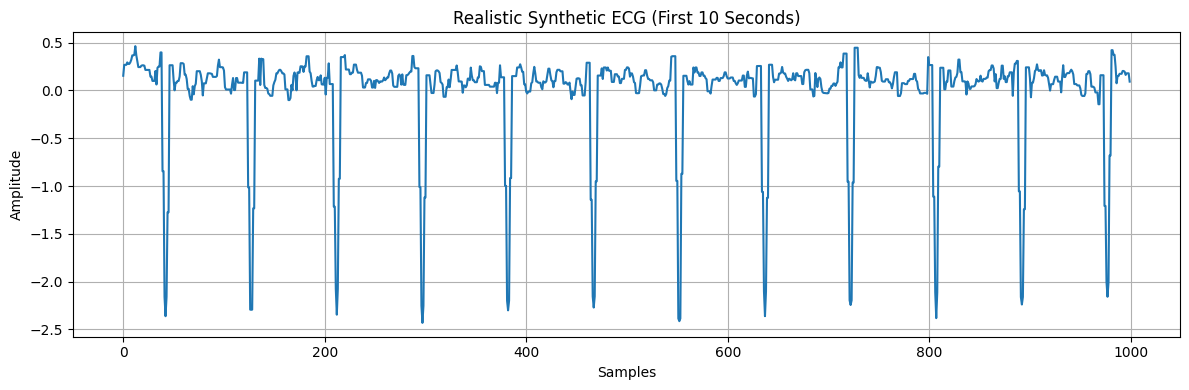

In [15]:
import numpy as np
from scipy.signal import butter, filtfilt, medfilt
import matplotlib.pyplot as plt

# Constants
FS = 100  # Sampling frequency in Hz
DURATION_SEC = 60 * 60  # 10 minutes
HEART_RATE = 70  # beats per minute

print("🧪 Generating realistic synthetic ECG data...")

def generate_realistic_ecg(duration_sec=600, fs=100, heart_rate=70, noise_std=0.01):
    t = np.arange(0, duration_sec, 1/fs)
    beats_per_sec = heart_rate / 60
    beat_interval = int(fs / beats_per_sec)

    # Simple custom QRS-like shape (spike)
    qrs_duration = int(0.1 * fs)  # QRS complex lasts ~100ms
    qrs = np.zeros(beat_interval)
    qrs_center = beat_interval // 2
    qrs[qrs_center - 1] = -0.5
    qrs[qrs_center] = 1.0
    qrs[qrs_center + 1] = -0.5

    # Repeat the QRS complex
    num_beats = int(duration_sec * beats_per_sec)
    ecg = np.zeros(len(t))
    for i in range(num_beats):
        start = i * beat_interval
        end = start + beat_interval
        if end < len(ecg):
            ecg[start:end] += qrs

    # Add Gaussian noise
    ecg += np.random.normal(0, noise_std, len(ecg))
    return ecg.astype(np.float32)

# Generate ECG
ecg_raw = generate_realistic_ecg(duration_sec=DURATION_SEC, fs=FS, heart_rate=HEART_RATE)
print("✅ Realistic ECG generated! Shape:", ecg_raw.shape)

# === Preprocessing Function ===
def preprocess_and_force_align(ecg_raw, fs):
    def highpass(signal):
        b, a = butter(2, 0.5 / (0.5 * fs), btype='high')
        return filtfilt(b, a, signal)

    def lowpass(signal):
        b, a = butter(2, 40 / (0.5 * fs), btype='low')
        return filtfilt(b, a, signal)

    def median(signal):
        return medfilt(signal, kernel_size=5)

    ecg = highpass(ecg_raw)
    ecg = lowpass(ecg)
    ecg = median(ecg)

    # Normalize
    ecg = (ecg - np.mean(ecg)) / np.std(ecg)
    ecg = ecg * 0.5
    return ecg

# === Apply preprocessing ===
ecg = preprocess_and_force_align(ecg_raw, FS)
print("✅ Preprocessing complete! ECG shape:", ecg.shape)

# Optional: Plot first 10 seconds
plt.figure(figsize=(12, 4))
plt.plot(ecg[:10 * FS])
plt.title("Realistic Synthetic ECG (First 10 Seconds)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Saved preprocessed ECG to 'forced_realistic_ecg_10min.csv' | Shape: (360000, 2)
✅ Detected 4265 heartbeats


c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sleepecg\feature_extraction.py:505: RuntimeWarning: HR analysis window too short for estimating PSD for feature VLF. 3030.3s required, got 270s
  warnings.warn(msg, category=RuntimeWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
✅ Sleep staging complete! Stages shape: (119,)


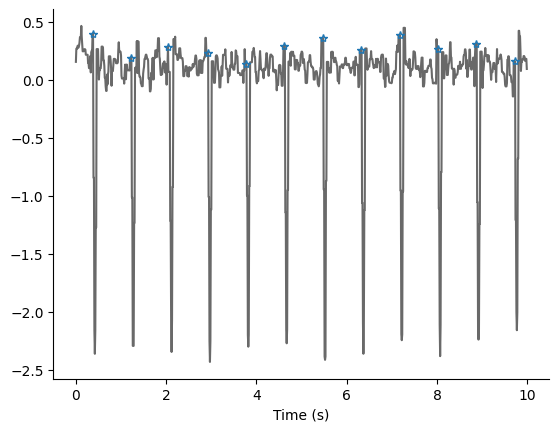

In [16]:
import pandas as pd
from datetime import datetime
import sleepecg

# === Save ECG to CSV ===
time_array = np.arange(len(ecg)) / FS
df = pd.DataFrame({'Time': time_array, 'ECG': ecg})
df.to_csv("forced_realistic_ecg_10min.csv", index=False)
print("✅ Saved preprocessed ECG to 'forced_realistic_ecg_10min.csv' | Shape:", df.shape)

# === Detect R-peaks (heartbeats) ===
beats = sleepecg.detect_heartbeats(ecg, FS)
print(f"✅ Detected {len(beats)} heartbeats")

# === (Optional) Plot first 10 seconds ===
sleepecg.plot_ecg(ecg[:10 * FS], FS, beats=beats[beats < 10 * FS])

# === Create SleepRecord (30s epochs) ===
start_time = datetime(2023, 1, 1, 23, 0, 0)  # Fake start time
record = sleepecg.SleepRecord(
    sleep_stage_duration=30,
    recording_start_time=start_time,
    heartbeat_times=beats / FS,
)

# === Load pretrained model and predict sleep stages ===
clf = sleepecg.load_classifier("wrn-gru-mesa", "SleepECG")
stages = sleepecg.stage(clf, record)

print("✅ Sleep staging complete! Stages shape:", stages.shape)


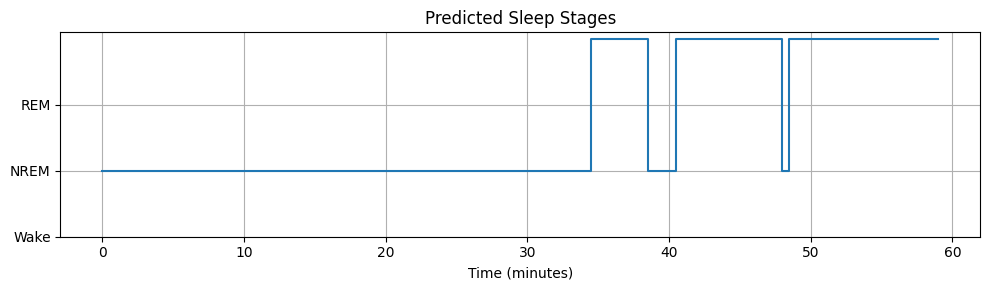

In [17]:
# Plot hypnogram
fig, ax = plt.subplots(figsize=(10, 3))
t_hypno = np.arange(len(stages)) * 30 / 60  # convert to minutes
ax.plot(t_hypno, stages, drawstyle="steps-post")
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(["Wake", "NREM", "REM"])
ax.set_xlabel("Time (minutes)")
ax.set_title("Predicted Sleep Stages")
ax.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# ✅ Count occurrences of each stage
unique, counts = np.unique(stages, return_counts=True)
stage_names = {0: "Wake", 1: "NREM", 2: "REM"}
stage_percentages = {stage_names.get(k, f"Stage {k}"): (v / len(stages)) * 100 for k, v in zip(unique, counts)}

# ✅ Find dominant stage
dominant_stage = max(stage_percentages, key=stage_percentages.get)
dominant_percent = stage_percentages[dominant_stage]

# ✅ Print summary
print("\n📊 Sleep Stage Distribution:")
for stage, percent in stage_percentages.items():
    print(f"  {stage}: {percent:.2f}%")

print(f"\n🛌 The dominant sleep stage is: **{dominant_stage}** ({dominant_percent:.2f}%)")



📊 Sleep Stage Distribution:
  NREM: 62.18%
  Stage 3: 37.82%

🛌 The dominant sleep stage is: **NREM** (62.18%)
